In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

import tensorflow as tf
rand_state = np.random.randint(0, 100)
tf.set_random_seed(rand_state)
np.random.seed(rand_state)

from skimage import exposure
import cv2
import glob
import time
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model

Using TensorFlow backend.


# Introduction  

"What would you say if I told you there is a app on the market that tell you if you have a hotdog or not a hotdog. It is very good and I do not want to work on it any more. You can hire someone else." - Jian-Yang, [Silicon Valley](https://www.youtube.com/watch?v=ACmydtFDTGs)

Sounds simple enough, right? It's actually a little more complex, referring to the theory behind convolutional neural networks (CNN) and their applications in image classification. However, Keras makes it relatively easy to setup and evaluate a CNN!  

The objective of this project is simple: given a picture, does it contain a hot dog or not?

## Data

This data was extracted from the Food 101 dataset. A full version of the dataset is available [here](https://www.kaggle.com/dansbecker/food-101). This is a binary classification task, while not very interesting a similar approach can be taken to extend this to multiple food categories. Note that multiple terms can refer to what is essentially the same object, in this case the difference appears to primarily be regional: a frankfurter, wienerwurst or hot dog. Thanks to [DanB](https://www.kaggle.com/dansbecker) for extracting the dataset ([kaggle](https://www.kaggle.com/dansbecker/hot-dog-not-hot-dog)) 

To simplify this project, the data is completely balanced: 50% hot dog images and 50% not hot dog images. We will then use 498 images to train our model, and 500 labeled images to test it on.

**Data augmentation**:  
Neural networks perform much better when fed large amounts of data, and we only have 500 images for each class. We could just download more images from a source like ImageNet, but I will just augment this data set: add random rotation and or blur to our existing images to get 20,000 images for each class. **I also resize the images to 32 x 32.**

In [2]:
def rotateImage(img, angle):
    (rows, cols, ch) = img.shape
    M = cv2.getRotationMatrix2D((cols/2,rows/2), angle, 1)
    return cv2.warpAffine(img, M, (cols,rows))
    
    
def loadBlurImg(path, imgSize):
    img = cv2.imread(path)
    angle = np.random.randint(0, 360)
    img = rotateImage(img, angle)
    img = cv2.blur(img,(5,5))
    img = cv2.resize(img, imgSize)
    return img

def loadImgClass(classPath, classLable, classSize, imgSize):
    x = []
    y = []
    
    for path in classPath:
        img = loadBlurImg(path, imgSize)        
        x.append(img)
        y.append(classLable)
        
    while len(x) < classSize:
        randIdx = np.random.randint(0, len(classPath))
        img = loadBlurImg(classPath[randIdx], imgSize)
        x.append(img)
        y.append(classLable)
        
    return x, y

def loadData(img_size, classSize):
    hotdogs = glob.glob('./hotdog/**/*.jpg', recursive=True)
    notHotdogs = glob.glob('./not-hotdog/**/*.jpg', recursive=True)
    
    
    imgSize = (img_size, img_size)
    xHotdog, yHotdog = loadImgClass(hotdogs, 0, classSize, imgSize)
    xNotHotdog, yNotHotdog = loadImgClass(notHotdogs, 1, classSize, imgSize)
    print("There are", len(xHotdog), "hotdog images")
    print("There are", len(xNotHotdog), "not hotdog images")
    
    X = np.array(xHotdog + xNotHotdog)
    y = np.array(yHotdog + yNotHotdog)
    
    return X, y

Normalization and histogram [equalization](https://en.wikipedia.org/wiki/Histogram_equalization)

In [3]:
def toGray(images):
    # rgb2gray converts RGB values to grayscale values by forming a weighted sum of the R, G, and B components:
    # 0.2989 * R + 0.5870 * G + 0.1140 * B 
    # source: https://www.mathworks.com/help/matlab/ref/rgb2gray.html
    
    images = 0.2989*images[:,:,:,0] + 0.5870*images[:,:,:,1] + 0.1140*images[:,:,:,2]
    return images

def normalizeImages(images):
    # use Histogram equalization to get a better range
    # source http://scikit-image.org/docs/dev/api/skimage.exposure.html#skimage.exposure.equalize_hist
    images = (images / 255.).astype(np.float32)
    
    for i in range(images.shape[0]):
        images[i] = exposure.equalize_hist(images[i])
    
    images = images.reshape(images.shape + (1,)) 
    return images

def preprocessData(images):
    grayImages = toGray(images)
    return normalizeImages(grayImages)

In [4]:
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split

size = 32
classSize = 20000
'''
I saved the transformed images (of size 20000,128,128,1) so I do not have to recreate it

scaled_X, y = loadData(size, classSize)
scaled_X = preprocessData(scaled_X)
scaled_X.tofile('scaled_X.dat')
'''
scaled_X, y = loadData(size, classSize)
scaled_X = preprocessData(scaled_X)
y = to_categorical(y)
#y.tofile('y.dat')

# scaled_X = np.fromfile('scaled_X.dat', dtype=float)
# scaled_X = scaled_X.reshape((classSize,size,size,1))


# y = np.fromfile('y.dat', dtype=float)
n_classes=2
print("y shape", y.shape)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, 
                                                    test_size=0.2, 
                                                    random_state=rand_state)

print("train shape X", X_train.shape)
print("train shape y", y_train.shape)
print("Test shape X:", X_test.shape)
print("Test shape y: ", y_test.shape)

inputShape = (size, size, 1)

There are 20000 hotdog images
There are 20000 not hotdog images
y shape (40000, 2)
train shape X (32000, 32, 32, 1)
train shape y (32000, 2)
Test shape X: (8000, 32, 32, 1)
Test shape y:  (8000, 2)


In [5]:
# Change shape 
# Note that our images are 128*128 pixels, so in reshaping to arrays we want
# 4,000 arrays of length 16384, one for each image
X_train_reshaped = X_train.reshape(X_train.shape[0], size*size)
X_test_reshaped = X_test.reshape(X_test.shape[0], size*size)

# Print sample sizes
print(X_train_reshaped.shape[0], 'train samples')
print(X_test_reshaped.shape[0], 'test samples')

32000 train samples
8000 test samples


In [6]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Models  

## Multi Layer Perceptron  
_Feedforward neural network_

======================

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 256)               262400    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 514       
Total params: 328,706
Trainable params: 328,706
Non-trainable params: 0
_________________________________________________________________
Train on 32000 samples, validate on 8000 samples
Epoch 1/100
32000/32000 [==============================] - 8s 243us/step - loss: 1.9953

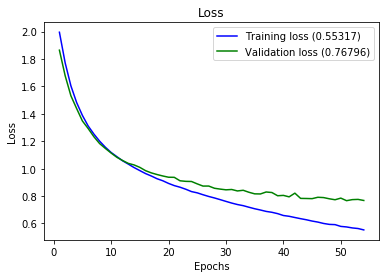

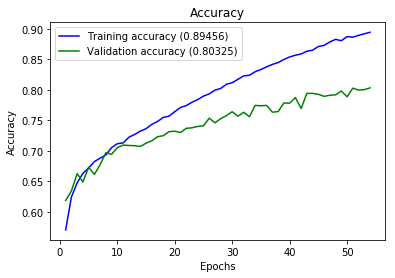

In [10]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint

start = time.time()
# Start with a simple sequential model
model_1 = Sequential()

# Add dense layers to create a fully connected MLP
# Note that we specify an input shape for the first layer, but only the first layer.
# Relu is the activation function used
model_1.add(Dense(256, activation='relu',
                  kernel_initializer='he_normal',
                  kernel_regularizer=keras.regularizers.l1_l2(l1=.0001, l2=.001), 
                  input_shape=(size*size,)))
# Dropout layers remove features and fight overfitting
model_1.add(Dropout(0.2))
model_1.add(Dense(256, activation='relu', activity_regularizer=keras.regularizers.l2(.0001)))
model_1.add(Dropout(0.2))
# End with a number of units equal to the number of classes we have for our outcome
model_1.add(Dense(2, activation='softmax'))

model_1.summary()

# Set callback functions to early stop training and save the best model so far
callbacks_1 = [EarlyStopping(monitor='val_loss', patience=3),
             ModelCheckpoint(filepath='model_1.h5', monitor='val_acc', save_best_only=True)]

# Compile the model to put it all together.
model_1.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adamax(lr=1e-4),
              metrics=['accuracy'])

history_1 = model_1.fit(X_train_reshaped, y_train,
                      batch_size=16,
                      epochs=100,
                      callbacks=callbacks_1,
                      verbose=1, 
                      validation_data=(X_test_reshaped, y_test))

end = time.time()
print("Execution time: {}\n".format(end-start))

plot_history(history_1)

With early stopping (max of 50), our best model comes at **55** epochs where we achieve an accuracy of **80.32%** on the test set. Notice that after about epoch 10 the gap between train and test accuracy grows, indicating that the model begins to overfit the train data (89% on the test set).  

By simply rescaling the input images to 32 by 32, we sped our MLP model up to train in under 7 minutes!

## Convolutional Neural Network (CNN)

In [11]:
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization


model_2 = Sequential()
model_2.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 kernel_initializer='he_normal',
                 input_shape=inputShape))
model_2.add(MaxPooling2D((2, 2)))
model_2.add(Dropout(0.25))
model_2.add(Conv2D(64, (3, 3), activation='relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.25))
model_2.add(Conv2D(128, (3, 3), activation='relu'))
model_2.add(Dropout(0.4))
model_2.add(Flatten())
model_2.add(Dense(128, activation='relu'))
model_2.add(Dropout(0.3))
model_2.add(Dense(2, activation='softmax'))

model_2.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adam(lr=1e-4),
              metrics=['accuracy'])

start = time.time()

model_2.summary()
# Set callback functions to early stop training and save the best model so far
callbacks_2 = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint(filepath='model_2.h5', monitor='val_acc', save_best_only=True)]

history_2 = model_2.fit(X_train, y_train,
                      batch_size=16,
                      epochs=100, 
                      callbacks=callbacks_2,
                      verbose=1,
                      validation_data=(X_test, y_test))

end = time.time()
print('Execution time: ', end-start)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 128)         73856     
__________

Epoch 46/100
32000/32000 [==============================] - 41s 1ms/step - loss: 0.1910 - acc: 0.9232 - val_loss: 0.1488 - val_acc: 0.9495
Epoch 47/100
32000/32000 [==============================] - 37s 1ms/step - loss: 0.1857 - acc: 0.9248 - val_loss: 0.1475 - val_acc: 0.9505
Epoch 48/100
32000/32000 [==============================] - 37s 1ms/step - loss: 0.1840 - acc: 0.9250 - val_loss: 0.1445 - val_acc: 0.9507
Epoch 49/100
32000/32000 [==============================] - 37s 1ms/step - loss: 0.1792 - acc: 0.9290 - val_loss: 0.1419 - val_acc: 0.9517
Epoch 50/100
32000/32000 [==============================] - 40s 1ms/step - loss: 0.1780 - acc: 0.9294 - val_loss: 0.1328 - val_acc: 0.9544
Epoch 51/100
32000/32000 [==============================] - 37s 1ms/step - loss: 0.1693 - acc: 0.9325 - val_loss: 0.1343 - val_acc: 0.9541
Epoch 52/100
32000/32000 [==============================] - 37s 1ms/step - loss: 0.1645 - acc: 0.9355 - val_loss: 0.1323 - val_acc: 0.9540
Epoch 53/100
32000/32000 [=

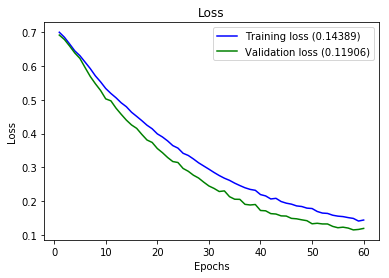

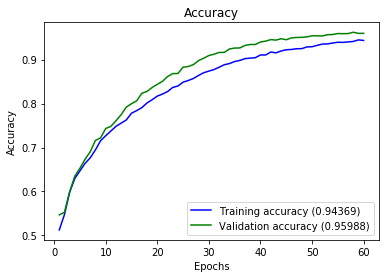

In [12]:
plot_history(history_2)

As I mentioned previously, it is not clear to me how you design a network architecture so I "borrowed" the one used [here](https://www.kaggle.com/bugraokcu/cnn-with-keras) (Fashion-MNIST dataset). I did tune the model:
  1. [Adam](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/) optimization algorithm
  2. learning rate to 0.0001
  3. Initialize weights using [He Normal](https://medium.com/@prateekvishnu/xavier-and-he-normal-he-et-al-initialization-8e3d7a087528)
  4. early stopping

Earlier models that I built (using this architecture) suffered from really bad overfitting, but rescaling the input images, and doubling the number of examples I was able to overcome this problem, as well as significantly speeding up training. resulting in 

Our final model was at epoch 16 and achieved **96.24**% accuracy on the test set! This model also slightly underfit the data (not such a bad thing here). Note this model did take 39 minutes to train.

## Hierarchical Recurrrent Neural Network  

[Link](http://www.telesens.co/2018/03/11/object-detection-and-classification-using-r-cnns/)

In [35]:
from keras.layers import Input, TimeDistributed, LSTM
from keras.models import Model
from keras import regularizers

row, col, pixel = X_train.shape[1:]

# 4D input.
x = Input(shape=(row, col, pixel))

lstm = LSTM(size, activation='relu')

# Encodes a row of pixels using TimeDistributed Wrapper.
encoded_rows = TimeDistributed(lstm)(x)

# Encodes columns of encoded rows.
encoded_columns = LSTM(size)(encoded_rows)

# Final predictions and model.
prediction = Dense(2, activation='softmax')(encoded_columns)
model_3 = Model(x, prediction)

model_3.summary()

model_3.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(lr=1e-3),
              metrics=['accuracy'])

start = time.time()

callbacks_3 = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint(filepath='model_3.h5', monitor='val_acc', save_best_only=True)]

# Training.
history_3 = model_3.fit(X_train, y_train,
                        batch_size=64,
                        epochs=20,
                        callbacks=callbacks_3,
                        verbose=1,
                        validation_data=(X_test, y_test))

end = time.time()
print('Execution time: ', end-start)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 32, 32, 1)         0         
_________________________________________________________________
time_distributed_15 (TimeDis (None, 32, 32)            4352      
_________________________________________________________________
lstm_30 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_26 (Dense)             (None, 2)                 66        
Total params: 12,738
Trainable params: 12,738
Non-trainable params: 0
_________________________________________________________________
Train on 32000 samples, validate on 8000 samples
Epoch 1/20
32000/32000 [==============================] - 75s 2ms/step - loss: 0.6866 - acc: 0.5514 - val_loss: 0.6746 - val_acc: 0.6035
Epoch 2/20
32000/32000 [==============================] - 68s 2ms/step - loss: 0.660

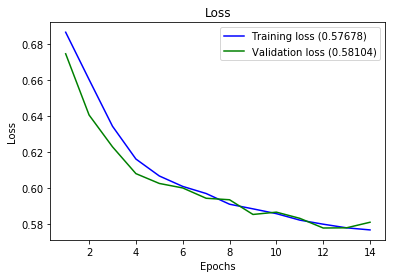

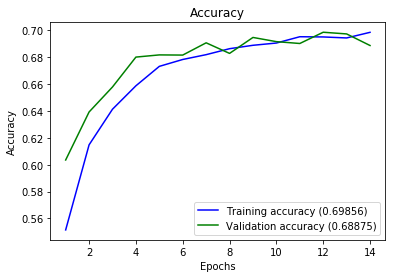

In [36]:
plot_history(history_3)

This model only took 19 minutes to train (versus 39 for our CNN), but was not very accurate. Bottom line: LSTM's would not be my go to for image classification, CNN's are perfect for this task! 